# Part 1: Initial Planning

## Robert, Dave and Stan
--------------------------------------------------------------------------------------------------------------------------------


### We hope to predict the winner of the 2018 NBA Playoffs 
### Collected data from 
  1. https://www.cbssports.com/nba/standings 
  2. https://www.kaggle.com/pablote/nba-enhanced-stats 
  3. https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2017-18&SeasonType=Regular%20Season 
                       

Import necessary libraries 

In [3]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import math

Read box statistics from 2016/2017 season and 2017/2018

In [4]:
team_box1617 = pd.read_csv("./2016-17_teamBoxScore.csv", sep=',', dtype = str)
player_box1617 = pd.read_csv("./2016-17_playerBoxScore.csv", sep=',', dtype = str)
official_box1617 = pd.read_csv("./2016-17_officialBoxScore.csv", sep=',', dtype = str)
standings1617 = pd.read_csv("./2016-17_standings.csv", sep=',', dtype = str)
team_box1718 = pd.read_csv("./2017-18_teamBoxScore.csv", sep=',', dtype = str)
player_box1718 = pd.read_csv("./2017-18_playerBoxScore.csv", sep=',', dtype = str)
official_box1718 = pd.read_csv("./2017-18_officialBoxScore.csv", sep=',', dtype = str)
standings1718 = pd.read_csv("./2017-18_standings.csv", sep=',', dtype = str)

Read csv file that has been scraped from cite 1.

In [5]:
names = ["Team", "W", "L", 'Pct', 'GB', 'Home', 'Road', "Conf", "Div", "Streak", "L10", "?"]
team_statistics = pd.read_csv("./scraping_attempt2.csv", sep = ',', dtype = str, names = names)
del team_statistics['?']
team_statistics.drop(0, inplace=True)
team_statistics.drop(16, inplace=True)
#team_statistics

Read csv files from end of year statistsics from the past 4 years

In [6]:
team_stats1415 = pd.read_csv("./Stats_14-15.csv", sep = ",")
team_stats1516 = pd.read_csv("./Stats_15-16.csv", sep = ",")
team_stats1617 = pd.read_csv("./Stats_16-17.csv", sep = ",")
team_stats1718 = pd.read_csv("./Stats_17-18.csv", sep = ",")

In [7]:
team_stats1415['GP'] = team_stats1415['W'] + team_stats1415['L']
team_stats1516['GP'] = team_stats1516['W'] + team_stats1516['L']
team_stats1617['GP'] = team_stats1617['W'] + team_stats1617['L']
team_stats1718['GP'] = team_stats1718['W'] + team_stats1718['L']

In [17]:
del team_stats1415["MIN"]
del team_stats1516["MIN"]
del team_stats1617["MIN"]
del team_stats1718["MIN"]

In [41]:
top_teams1415 = team_stats1415[team_stats1415["WIN%"] > .6]
top_teams1516 = team_stats1516[team_stats1516["WIN%"] > .6]
top_teams1617 = team_stats1516[team_stats1617["WIN%"] > .6]
top_teams1718 = team_stats1516[team_stats1718["WIN%"] > .6]

C:\Users\Robert\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [60]:
top_team_stats_1415 = top_teams1415[["TEAM", "W", "L", "WIN%", "PTS"]]
top_team_stats_1516 = top_teams1516[["TEAM", "W", "L", "WIN%", "PTS"]]
top_team_stats_1617 = top_teams1617[["TEAM", "W", "L", "WIN%", "PTS"]]
top_team_stats_1718 = top_teams1718[["TEAM", "W", "L", "WIN%", "PTS"]]

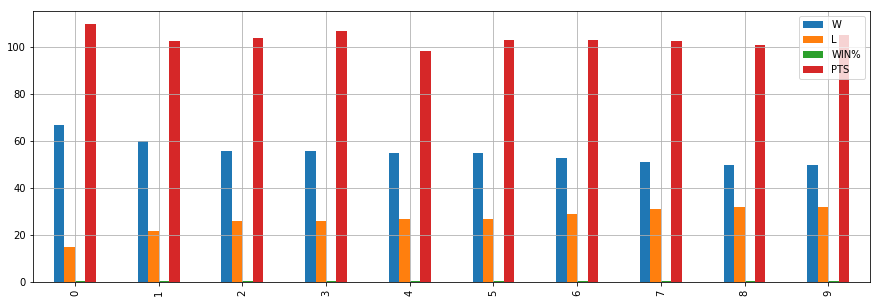

In [68]:
top_team_stats_1415.plot(figsize = (15, 5), kind="bar", grid = True)
